# Google Play Music and YouTube Music activity analysis

Grab your activity here https://takeout.google.com/

play_music.json - activity from Google Play Music

youtube.json - activity from YouTube Music

In [490]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [434]:
my_activity = pd.DataFrame(columns=['artist', 'song', 'datetime', 'platform'])

with open('play_music.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if i['title'].startswith('Listened to '):
            my_activity = my_activity.append({
                    'artist': i['description'].lower(), 
                    'song': i['title'].replace('Listened to ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'Play Music'},
                ignore_index=True)

with open('youtube.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if (i['header'] == 'YouTube Music' and 
                i['title'].startswith('Watched ') and
                i['subtitles'][0]['name'].endswith(' - Topic')):
            my_activity = my_activity.append({
                    'artist': i['subtitles'][0]['name'].replace(' - Topic', '').lower(), 
                    'song': i['title'].replace('Watched ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'YouTube Music'},
                ignore_index=True)

In [468]:
my_activity['datetime'] = pd.to_datetime(my_activity.datetime)
my_activity['month_name'] = my_activity.datetime.dt.strftime('%b')
my_activity['weekday_name'] = my_activity.datetime.dt.strftime('%a')
my_activity['hour'] = my_activity.datetime.dt.hour
my_activity['month_year_name'] = my_activity.datetime.dt.strftime('%b %Y')

my_activity = my_activity.sort_values('datetime')

In [469]:
my_activity.head()

,artist,song,datetime,platform,month_name,weekday_name,hour,month_year_name
12684,alt-j,breezeblocks,2017-07-15 05:40:47.715,Play Music,Jul,Sat,5,Jul 2017
12683,alt-j,(guitar),2017-07-15 05:44:35.154,Play Music,Jul,Sat,5,Jul 2017
12682,скриптонит,на должном,2017-07-17 07:52:53.619,Play Music,Jul,Mon,7,Jul 2017
12681,скриптонит,сны,2017-07-17 07:53:01.007,Play Music,Jul,Mon,7,Jul 2017
12680,скриптонит,вниз,2017-07-17 07:53:11.411,Play Music,Jul,Mon,7,Jul 2017


### Count of listening

In [470]:
len(my_activity.index)

13972

### Count of songs

In [486]:
len(my_activity.groupby(['artist', 'song'], as_index=False).any().index)

4748

### Count of artists

In [485]:
my_activity.artist.nunique()

1015

### Proportion of listening by platform

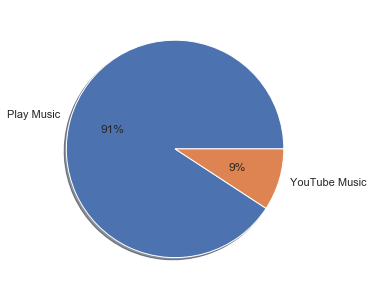

In [474]:
plt.figure(figsize=(5, 5))
data = my_activity.groupby('platform', as_index=False).agg({'datetime': 'count'})
plt.pie(x=data.datetime, labels=data.platform, autopct='%.0f%%', shadow=True)
plt.show()

### Bar chart of listening by month

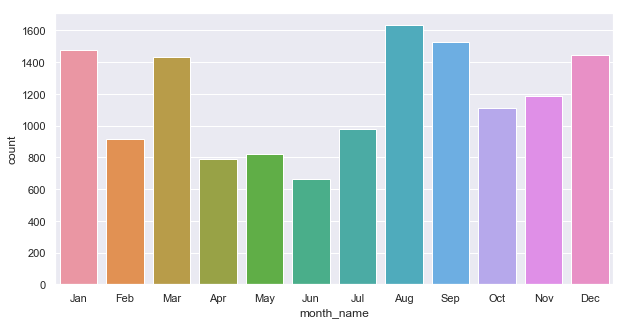

In [487]:
sns.set(rc={'figure.figsize':(10, 5)})
month_order = pd.date_range(pd.Timestamp('2019'), periods=12, freq='m').strftime('%b')
sns.countplot(x='month_name', order=month_order, data=my_activity)

### Bar chart of listening by hour and day of week

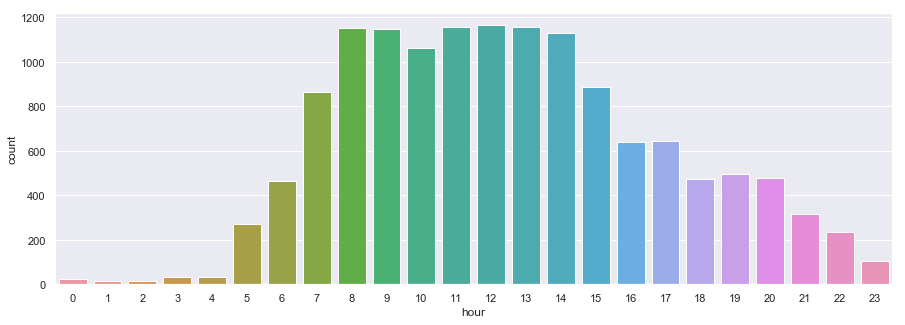

In [476]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x='hour', data=my_activity)

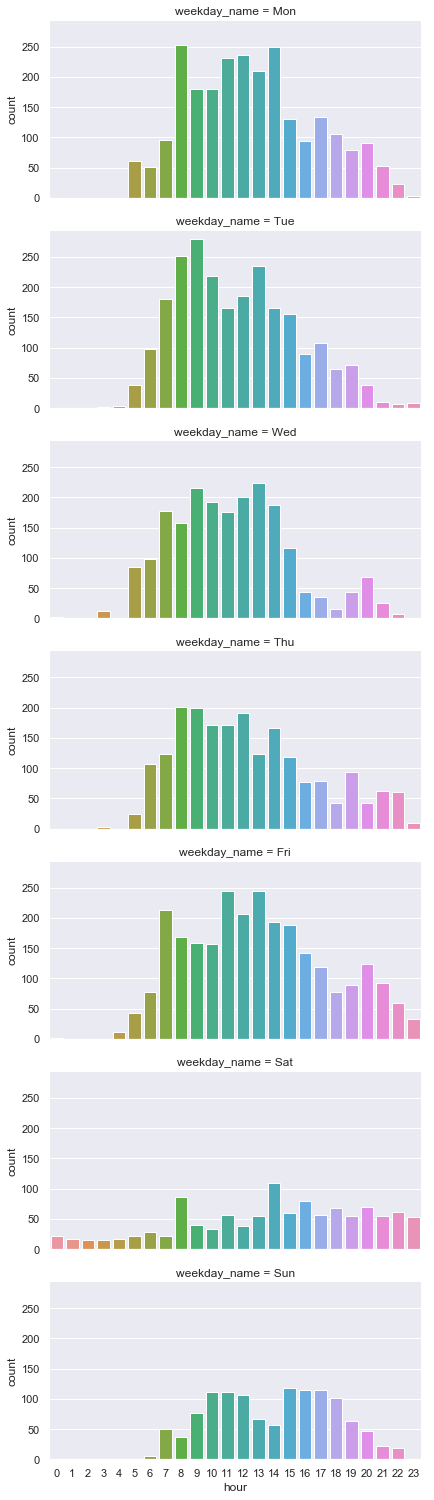

In [477]:
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
sns.catplot(x="hour", row="weekday_name", row_order=weekday_order, 
            height=3, aspect=2, data=my_activity, kind="count")

### Bar chart of listening by day of week

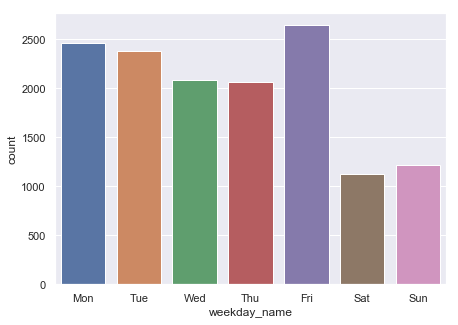

In [478]:
sns.set(rc={'figure.figsize':(7, 5)})
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
sns.countplot(x='weekday_name',
              order=weekday_order,
              data=my_activity)

### Bar chart of listening by period

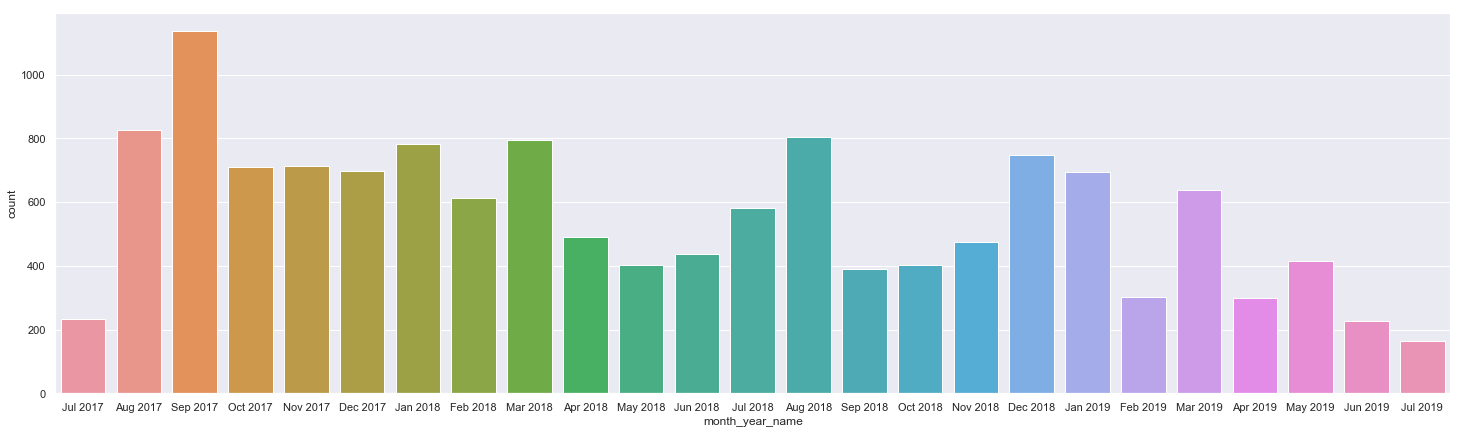

In [480]:
sns.set(rc={'figure.figsize':(25, 7)})
periods = my_activity.month_year_name.nunique()
start = my_activity.datetime.min()
sns.countplot(x='month_year_name', 
              order=pd.date_range(start, periods=periods, freq='m').strftime('%b %Y'),
              data=my_activity)

### Top 10 songs

In [483]:
top10_songs = my_activity. \
    groupby(['artist', 'song'], as_index=False). \
    aggregate({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_songs

,artist,song,count
689,eden,wrong,40
4313,скриптонит,животные,34
4289,синекдоха монток,ниточка в голове (),33
2042,pompeya,win,32
670,eden,crash,31
685,eden,take care,30
4270,свидание,я и твой кот,30
589,die antwoord,i fink u freeky,29
220,atl,танцуйте,29
4235,самое большое простое число,провал,29


### Top 10 artist

In [484]:
top10_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_artists

,artist,count
949,скриптонит,418
930,пионерлагерь пыльная радуга,411
773,ария,317
173,eden,310
757,аигел,284
73,billie eilish,242
943,самое большое простое число,234
501,pompeya,229
647,the handsome family,211
944,свидание,209
